# Hyperparameter Tuning Methods Comparision
# MLPClassifier on digits data

In [9]:
%matplotlib inline

In [10]:
%load_ext autoreload
%autoreload 2
%aimport hpt_cmp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
import warnings
warnings.filterwarnings('ignore')

In [12]:
import dataset_loader as ds
import model_loader as mdl
import seaborn as sns

from hpt_cmp import *

from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process, neural_network
from sklearn.metrics import accuracy_score, f1_score,roc_auc_score ,make_scorer, log_loss, recall_score
from tqdm import tqdm_notebook, tnrange
from skopt.space import Real, Integer, Categorical

In [13]:
# basic sklearn classification DS
dsBunch = ds.load('digits')
#dsBunch = ds.load('census_csv')
data = (dsBunch.data, dsBunch.target)
n_features = dsBunch.data.shape[1]
dsBunch.data.shape

(1797, 64)

# MLPClassifier

Parameters we tune for the MLPClassifier ([full documentation](http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier)):
> `hidden_layer_sizes`: tuple <br>
> `activation`: {'identity', 'logistic', 'tanh', *'relu'*} <br>
> `solver`: {‘lbfgs’, ‘sgd’, *‘adam’*} <br>
> `alpha`: float, *0.0001* --- regularization term <br>
> `learning_rate`: {*‘constant’*, ‘invscaling’, ‘adaptive’} <br>
> `learning_rate_init`: double, *0.001* <br>
> `random_state` <br>
> `momentum`: float, *0.9* <br>
> `nesterovs_momentum`: bool, *True* <br>
> `early_stopping`: bool, *False* <br>

In [14]:
d_features = n_features*4
hls = [(d_features,)*5, (n_features,)*5, (d_features,)*2, (n_features,)*2, (d_features,), (n_features),]
alpha = [0.0001, 0.001, 0.01, 0.1]
lr = ['adaptive'] #,'constant','invscaling']
lr_init = [0.00001, 0.0001, 0.001, 0.01, 0.1]
rs = [1]

# sklean paramgrid
pg = {
    'hidden_layer_sizes': hls,
    'alpha': alpha,
    'learning_rate': lr,
    'learning_rate_init': lr_init,
    'random_state': rs
}

# hyperopt paramgird
hg={
    'hidden_layer_sizes': hp.choice('hidden_layer_sizes',hls),
    'alpha': hp.loguniform('alpha', np.log(alpha[0]), np.log(alpha[-1])),
    'learning_rate': hp.choice('learning_rate',lr),
    'learning_rate_init': hp.loguniform('learning_rate_init', np.log(lr_init[0]),np.log(lr_init[-1])),
    'random_state': hp.choice('random_state', rs)
}

# skopt paramgrid 
bg = {
    'hidden_layer_sizes': Categorical(hls),
    'alpha': Real(alpha[0], alpha[-1], 'loguniform'),
    'learning_rate': Categorical(lr),
    'learning_rate_init': Real(lr_init[0],lr_init[-1], 'logunifrom'),
    'random_state': rs
}

# base model parameters
base = {
    'hidden_layer_sizes':(n_features,), 
    'alpha':0.001,
    'learning_rate': lr[0],
    'learning_rate_init': 0.001,
    'random_state':1}

In [15]:
# define MLPClassifier
hpt_objs = [
        HPT_OBJ('Baseline', base, run_baseline, {}),
        HPT_OBJ('Tree of Parzen Est.', hg, tpe_search, {}),
        #HPT_OBJ('Grid Search', pg, grid_search, {}),
        HPT_OBJ('Random Search', pg, random_search, {'n_iter': MAX_ITER}),
]

gr_objs = [
    HPT_OBJ('Grid Search', pg, grid_search, {'n_jobs':-1}),
    HPT_OBJ('Bayes Search', bg, baysian_search, {'n_iter':MAX_ITER}),
]

# loss = {
#     'acc': make_scorer(accuracy_score),
#     'loss': make_scorer(log_loss, greater_is_better=False, needs_proba=True, labels=dsBunch.target),
#     make_scorer(log_loss(lables=dsBunch.target_names)),
#     'recall': make_scorer(recall_score)
# }

mlpc ={
    'model': neural_network.MLPClassifier,
    'hpt_objs': hpt_objs,
    'loss': make_scorer(accuracy_score),
    'metric': accuracy_score,
    'name': 'digits'
}

In [29]:
res_gr = cmp_hpt_methods(data, 
                         model=neural_network.MLPClassifier, 
                         hpt_objs=gr_objs, 
                         loss=make_scorer(accuracy_score), 
                         metric=accuracy_score)

40 3


In [16]:
# run tuning with all the specified algorithms
res = cmp_hpt_methods(data, **mlpc)

40 3


In [30]:
sum_res = []
for r in res:
    t = np.array(r[INNER_RES]['mean_fit_time']).mean()
    #if r[HPT_METHOD] == 'Bayes Search':
    sum_res.append((r[HPT_METHOD], r[CV_TIME],len(r[INNER_RES]['params']), r[TEST_ACC], r[BEST_PARAMS], np.array(r[INNER_RES]['mean_test_score']).mean() ))
    #else:
     #   sum_res.append((r[HPT_METHOD], t, len(r[INNER_RES]['params']), r[TEST_ACC], r[BEST_PARAMS], np.array(r[INNER_RES]['mean_test_acc']).mean() ))
                   
df = pd.DataFrame(sum_res, columns=[HPT_METHOD, 'TIME', PARAMS_SAMPLED, TEST_ACC, BEST_PARAMS, 'SCORE'])

In [31]:
res.append(res_gr[0])
res.append(res_gr[1])


In [56]:
res
res_new = [res[0], res[3], res[2], res[4], res[1]]
for r in res_new:
    print(r[HPT_METHOD])
res = res_new

Baseline
Grid Search
Random Search
Bayes Search
Tree of Parzen Est.


In [57]:
sum_res = []
for r in res:
    try:
        sum_res.append((r[HPT_METHOD], r[CV_TIME],len(r[INNER_RES]['params']), r[TEST_ACC], r[BEST_PARAMS], np.array(r[INNER_RES]['mean_test_score']).mean() ))
    except Exception as e:
        print(e)
        print(type(r))
        print(r)
        print(type(r[INNER_RES]))
        
df = pd.DataFrame(sum_res, columns=[HPT_METHOD, 'TIME', PARAMS_SAMPLED, TEST_ACC, BEST_PARAMS, 'SCORE'])

In [58]:
df

,HPT method,TIME,Parameters sampled,Test accuracy,Best Parameters,SCORE
0,Baseline,5.455942,1,0.961111,"{'hidden_layer_sizes': (64,), 'alpha': 0.001, ...",0.965879
1,Grid Search,1376.865943,120,0.972222,"{'alpha': 0.001, 'hidden_layer_sizes': (256, 2...",0.762097
2,Random Search,492.560973,40,0.972222,"{'random_state': 1, 'learning_rate_init': 0.00...",0.806072
3,Bayes Search,1206.786946,40,0.983333,"{'alpha': 0.0011618620795301195, 'hidden_layer...",0.921990
4,Tree of Parzen Est.,417.649595,40,0.972222,"{'alpha': 0.0016508477942871504, 'hidden_layer...",0.942448


In [60]:
pd.DataFrame(df[BEST_PARAMS].tolist())

,alpha,hidden_layer_sizes,learning_rate,learning_rate_init,random_state
0,0.001000,"(64,)",adaptive,0.001000,1
1,0.001000,"(256, 256)",adaptive,0.001000,1
2,0.001000,"(256, 256)",adaptive,0.001000,1
3,0.001162,"(256, 256, 256, 256, 256)",adaptive,0.001599,1
4,0.001651,"(256, 256, 256, 256, 256)",adaptive,0.000552,1


[Text(0, 0, 'Baseline'),
 Text(0, 0, 'Grid'),
 Text(0, 0, 'Random'),
 Text(0, 0, 'Bayes'),
 Text(0, 0, 'TPE')]

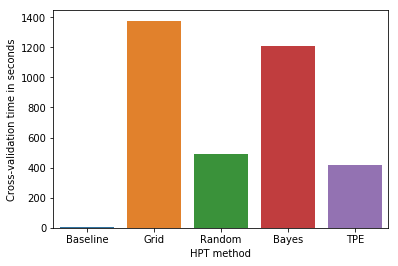

<Figure size 432x288 with 0 Axes>

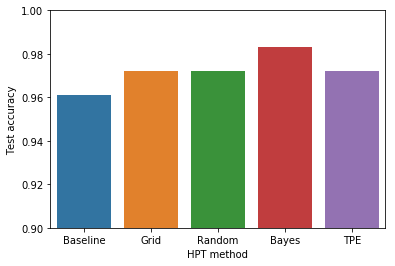

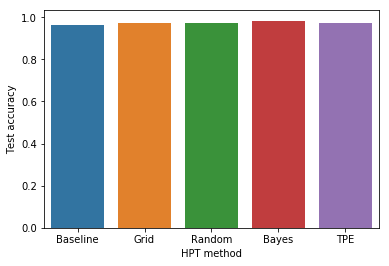

In [74]:
# plot comparison
fig, ax=plt.subplots()
sns.barplot(y='TIME', x=HPT_METHOD,data =df,ax=ax)
ax.set_ylabel('Cross-validation time in seconds')
ax.set_xticklabels(['Baseline','Grid', 'Random', 'Bayes', 'TPE'])
plt.figure()
# plot accuracy comparison
fig, ax =plt.subplots()
ax.set(ylim=(0.9, 1.0))
sns.barplot(y=TEST_ACC, x=HPT_METHOD, ax=ax,data =df)
ax.set_xticklabels(['Baseline','Grid', 'Random', 'Bayes', 'TPE'])
fig, ax =plt.subplots()
#ax.set(ylim=(0.9, 1.0))
sns.barplot(y=TEST_ACC, x=HPT_METHOD, ax=ax,data =df)
ax.set_xticklabels(['Baseline','Grid', 'Random', 'Bayes', 'TPE'])

In [62]:
pd.DataFrame(df[BEST_PARAMS].tolist())

,alpha,hidden_layer_sizes,learning_rate,learning_rate_init,random_state
0,0.001000,"(64,)",adaptive,0.001000,1
1,0.001000,"(256, 256)",adaptive,0.001000,1
2,0.001000,"(256, 256)",adaptive,0.001000,1
3,0.001162,"(256, 256, 256, 256, 256)",adaptive,0.001599,1
4,0.001651,"(256, 256, 256, 256, 256)",adaptive,0.000552,1


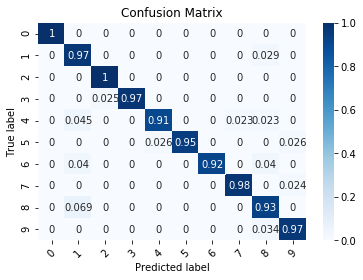

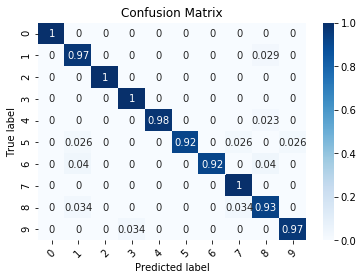

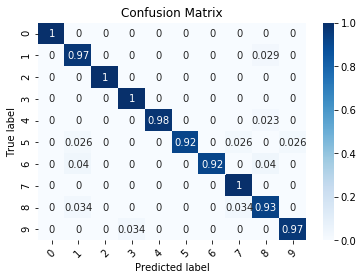

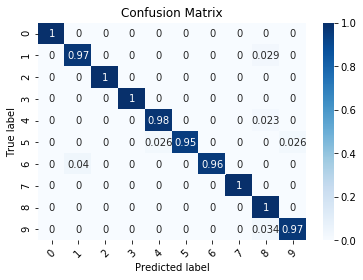

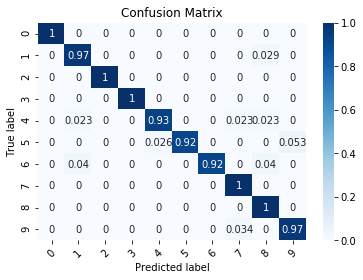

In [63]:
for r in res:
    plot_confusion_matrix(r[CONF_MATRIX], dsBunch.target_names)

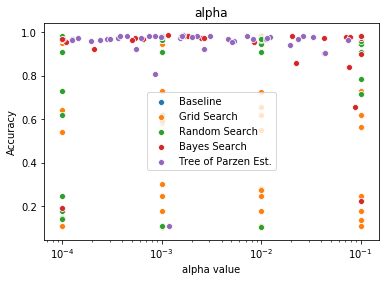

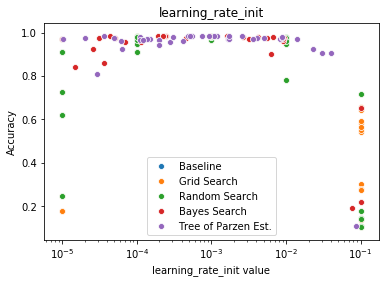

In [73]:
for param in ['alpha', 'learning_rate_init']:
    fig, ax = plt.subplots()
    ax.set_xscale('log')
    for r in res:
        ax = sns.scatterplot(x='param_'+param, y='mean_test_score', data=r[INNER_RES], label=r[HPT_METHOD])
    ax.set_title(param)
    ax.set_xlabel(param+' value')
    ax.set_ylabel('Accuracy')

In [65]:
pd.DataFrame(res[1][INNER_RES])


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_hidden_layer_sizes,param_learning_rate,param_learning_rate_init,param_random_state,params,...,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,86.580926,0.745269,0.048237,0.004136,0.0001,"(256, 256, 256, 256, 256)",adaptive,1e-05,1,"{'alpha': 0.0001, 'hidden_layer_sizes': (256, ...",...,0.979167,0.955789,0.970772,0.010560,39,0.994764,0.994775,0.997921,0.995820,0.001485
1,36.918901,5.426082,0.072527,0.019537,0.0001,"(256, 256, 256, 256, 256)",adaptive,0.0001,1,"{'alpha': 0.0001, 'hidden_layer_sizes': (256, ...",...,0.991667,0.974737,0.983299,0.006901,3,1.000000,1.000000,1.000000,1.000000,0.000000
2,9.814791,0.314857,0.049200,0.001244,0.0001,"(256, 256, 256, 256, 256)",adaptive,0.001,1,"{'alpha': 0.0001, 'hidden_layer_sizes': (256, ...",...,0.981250,0.974737,0.980515,0.004413,12,1.000000,1.000000,1.000000,1.000000,0.000000
3,12.068522,0.346896,0.035177,0.005136,0.0001,"(256, 256, 256, 256, 256)",adaptive,0.01,1,"{'alpha': 0.0001, 'hidden_layer_sizes': (256, ...",...,0.972917,0.962105,0.970077,0.005672,43,0.998953,0.996865,0.997921,0.997913,0.000852
4,35.935583,18.273977,0.039333,0.004277,0.0001,"(256, 256, 256, 256, 256)",adaptive,0.1,1,"{'alpha': 0.0001, 'hidden_layer_sizes': (256, ...",...,0.108333,0.111579,0.105080,0.006978,118,0.095288,0.108673,0.111227,0.105063,0.006990
5,24.277847,1.309275,0.018669,0.009454,0.0001,"(64, 64, 64, 64, 64)",adaptive,1e-05,1,"{'alpha': 0.0001, 'hidden_layer_sizes': (64, 6...",...,0.712500,0.732632,0.727905,0.011178,81,0.752880,0.768025,0.755717,0.758874,0.006574
6,22.305054,0.249637,0.010749,0.000791,0.0001,"(64, 64, 64, 64, 64)",adaptive,0.0001,1,"{'alpha': 0.0001, 'hidden_layer_sizes': (64, 6...",...,0.972917,0.955789,0.967293,0.008083,47,1.000000,1.000000,1.000000,1.000000,0.000000
7,6.240455,0.756746,0.021484,0.010054,0.0001,"(64, 64, 64, 64, 64)",adaptive,0.001,1,"{'alpha': 0.0001, 'hidden_layer_sizes': (64, 6...",...,0.972917,0.970526,0.973556,0.002752,31,1.000000,1.000000,1.000000,1.000000,0.000000
8,3.582191,0.760250,0.015916,0.007927,0.0001,"(64, 64, 64, 64, 64)",adaptive,0.01,1,"{'alpha': 0.0001, 'hidden_layer_sizes': (64, 6...",...,0.979167,0.962105,0.967293,0.008432,47,0.992670,1.000000,0.987526,0.993399,0.005118
9,2.685664,0.841847,0.011823,0.004879,0.0001,"(64, 64, 64, 64, 64)",adaptive,0.1,1,"{'alpha': 0.0001, 'hidden_layer_sizes': (64, 6...",...,0.104167,0.105263,0.144050,0.055374,110,0.197906,0.105538,0.104990,0.136145,0.043672


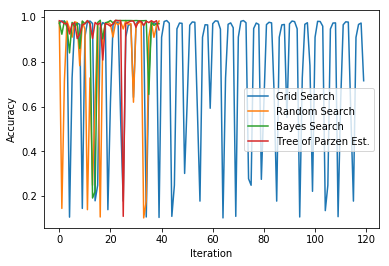

In [72]:
fig, ax = plt.subplots()
ax.set_ylabel('Accuracy')
ax.set_xlabel('Iteration')
for r in res:
    if r[HPT_METHOD] == 'Baseline': continue
    d = r[INNER_RES]['mean_test_score']
    sns.lineplot(x=[i for i in range(len(d))], y=d, label=r[HPT_METHOD])